# 代码实现

我们编程实现互相关公式，并测试下是否可以达到想要的模板匹配效果。

In [2]:
# utils 为之前章节已经撰写完成的函数包
from utils import *

import cv2
from matplotlib import pyplot as plt
import numpy as np

# 计算互相关
def CCORR(img, temp):
    w, h = temp.shape[::-1]
    W, H = img.shape[::-1]
    img = np.array(img, dtype='float')
    temp = np.array(temp, dtype='float')
    res = np.zeros((W - w + 1, H - h + 1))
    
    # 利用循环计算互相关的值
    for i in range(W - w + 1):
        for j in range(H - h + 1):
            res[i, j] = np.sum(temp * img[j:j + h, i:i + w])
    return res
    

# 构建单目标匹配类
class temp_match_single():
    def __init__(self, img, temp):
        self.img = img
        self.temp = temp
        
    def match(self):
        # 输入目标图像
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        # 输入模板图像
        temp = cv2.cvtColor(self.temp, cv2.COLOR_BGR2GRAY)
        w, h = temp.shape[::-1]
        
        # 计算互相关
        res = CCORR(img, temp)
        
        # 找到互相关值最大的位置
        loc = np.where(res == np.max(res))
        top_left = [int(loc[0]), int(loc[1])]
        bottom_right = (top_left[0] + w, top_left[1] + h)
        
        # 将其框出
        cv2.rectangle(self.img, top_left, bottom_right, (255,255,255), 1)
        plot_image(self.img[:, :, ::-1], 'Matching Result by CCORR')

我们导入一张图像和一个模板，进行模板匹配。

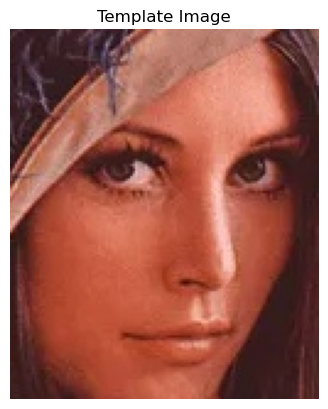

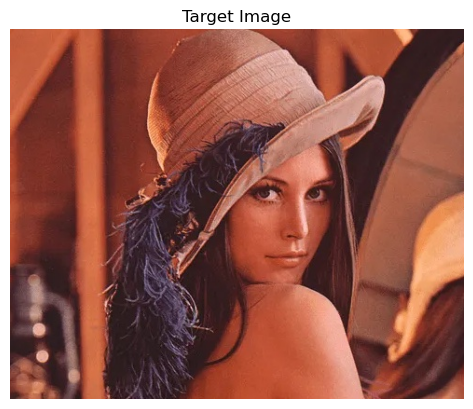

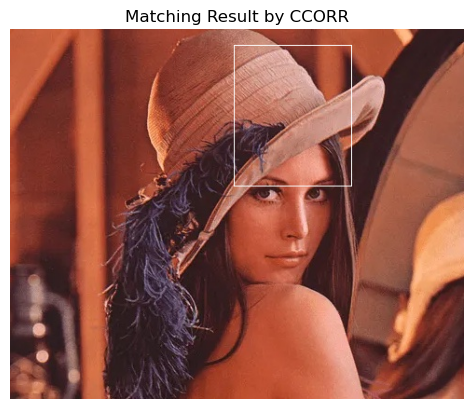

In [3]:
img = cv2.imread('lena_tri.jpg')
template = cv2.imread('lena_small.png')

test = temp_match_single(img, template)
plot_image(test.temp[:, :, ::-1], 'Template Image')
plot_image(test.img[:, :, ::-1], 'Target Image')

test.match()

结果有没有出乎大家的意料？我们并没有匹配到正确目标！问题出在哪里呢？给大家一点时间思考。

大家仔细观察互相关的公式，其结果是模板图像像素值和输入图像子图像素值直接相乘，那么在模板一定的情况下，子图整体像素值越大（也就是越亮），那么它们之间的乘积也就越大。所以互相关更容易找到输入图像中亮度高的区域，而不是和模板最相似的区域。那么如何解决这个问题呢？显然我们需要该相似度度量与输入图像中每个子图整体像素值大小无关，这就需要标准化。接下来我们引入另一种度量指标——标准化互相关。

#### 4.2.2.2 标准化互相关

再编程实现标准化互相关，这里重写CCORR()函数，再试试是否可以找到想要的目标区域。

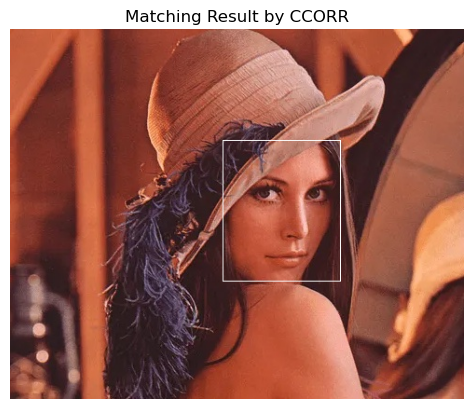

In [4]:
# 对原有CCORR()函数进行改写，定义标准化互相关
def CCORR(img, temp, normalize=True):
    w, h = temp.shape[::-1]
    W, H = img.shape[::-1]
    res = np.zeros((W-w+1, H-h+1))
    img = np.array(img, dtype='float')
    temp = np.array(temp, dtype='float')
    t = np.sqrt(np.sum(temp**2))
    for i in range(W-w+1):
        for j in range(H-h+1):
            res[i,j] = np.sum(temp*img[j:j+h, i:i+w])
            # 在这里进行归一化操作
            if normalize:
                res[i,j] = res[i,j] / t / np.sqrt(np.sum(img[j:j+h, i:i+w]**2)) 
    return res
    
img = cv2.imread('lena_tri.jpg')
template = cv2.imread('lena_small.png')

test = temp_match_single(img, template)

test.match()

由结果可见，我们通过标准化，消除了输入图像子图整体亮度变化对相似度计算的影响，提升了互相关度量的鲁棒性。

接下来，将实现多目标模板匹配。
为了方便，我们将直接使用标准化互相关作为度量指标，并直接调用库函数cv2.TM_CCORR_NORMED()来完成标准化互相关。

In [5]:
import numpy as np

# 利用快速排序算法找到数列中第k大的值
def findKth(s, k):
    return findKth_c(s, 0, len(s) - 1, k)


def findKth_c(s, low, high, k):
    m = partition(s, low, high)
    if m == len(s) - k:
        return s[m]
    elif m < len(s) - k:
        return findKth_c(s, m + 1, high, k)
    else:
        return findKth_c(s, low, m - 1, k)


def partition(s, low, high):
    pivot, j = s[low], low
    for i in range(low + 1, high + 1):
        if s[i] <= pivot:
            j += 1
            s[i], s[j] = s[j], s[i]
    s[j], s[low] = s[low], s[j]
    return j


# 构建多目标模板匹配类
class temp_match_multi():
    def __init__(self, img, temp, k=50):
        self.img = img
        self.temp = temp
        # 定义需要匹配的个数
        self.k = k
        
    def match(self):
        # 输入模板图像和目标图像
        temp = cv2.cvtColor(self.temp, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)

        w, h = temp.shape[::-1]
        method = eval('cv2.TM_CCORR_NORMED')
        res = cv2.matchTemplate(img, temp, method)
        temp = list(np.array(res).flatten())
        
        # 寻找res中第k大的值
        threshold = findKth(temp, self.k+1)
        print('设定的阈值为：', threshold)
        loc = np.where(res >= threshold)
        
        # 将找到的子图框选出
        for pt in zip(*loc[::-1]):
            cv2.rectangle(self.img, pt, (pt[0] + w, pt[1] + h), (255,255,255), 1)
            plt.imshow(self.img[:, :, ::-1]), plt.xticks([]), plt.yticks([])
        plt.show()

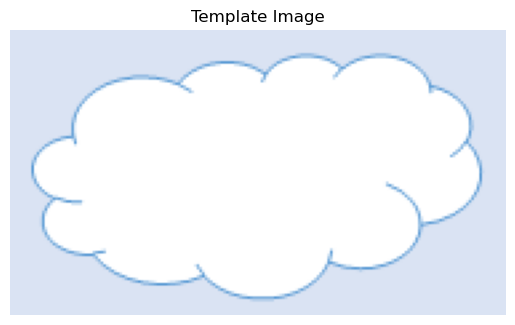

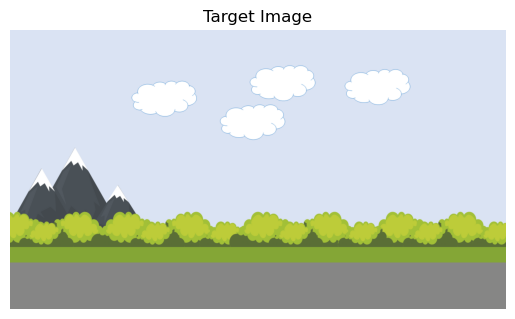

设定的阈值为： 0.99798167


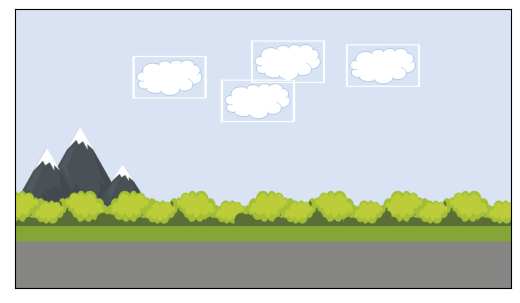

In [7]:
img = cv2.imread('img.png')
template = cv2.imread('temp.png')

test_multi = temp_match_multi(img, template, k=50)
plot_image(test_multi.temp[:, :, ::-1], 'Template Image')
plot_image(test_multi.img[:, :, ::-1], 'Target Image')
test_multi.match()